**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons
## The Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [7]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [8]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

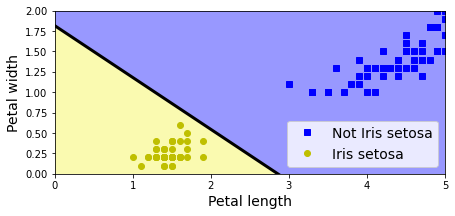

In [9]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

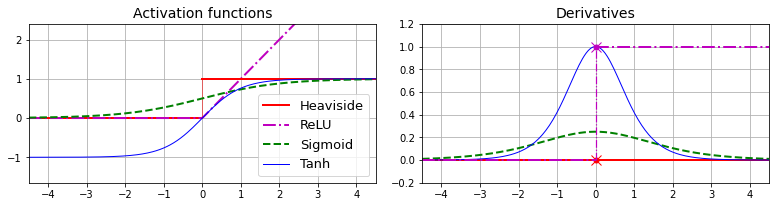

In [10]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [15]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [16]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [17]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

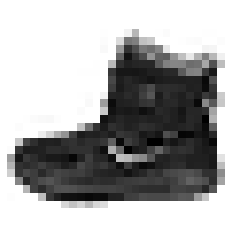

In [18]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [19]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [21]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

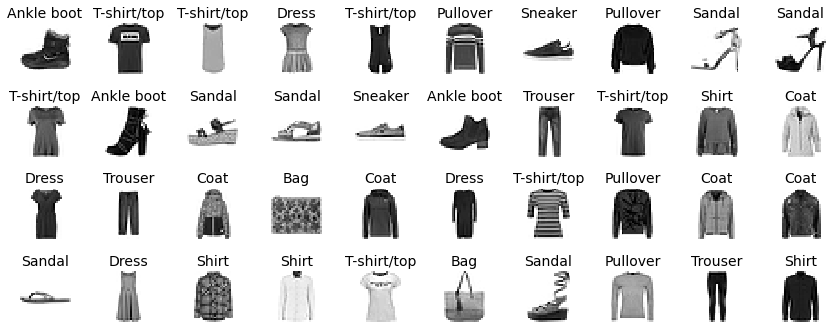

In [22]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model using the Sequential API

In [23]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [24]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


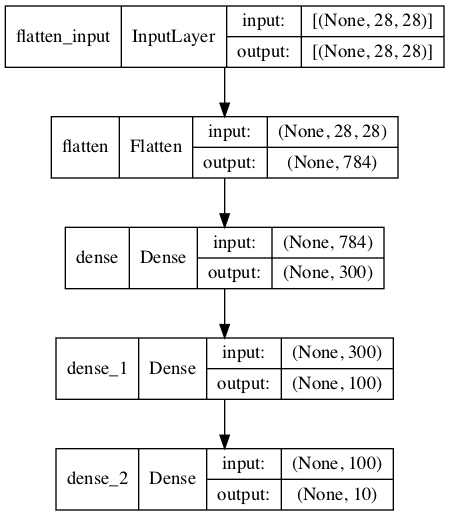

In [26]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [27]:
model.layers

In [28]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [29]:
model.get_layer('dense') is hidden1

True

In [30]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
biases.shape

(300,)

### Compiling the model

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [35]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [36]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [37]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Training and evaluating the model

In [38]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7220 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.4959 - val_sparse_categorical_accuracy: 0.8332
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4825 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.4567 - val_sparse_categorical_accuracy: 0.8384
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4369 - sparse_categorical_accuracy: 0.8480 - val_loss: 0.4228 - val_sparse_categorical_accuracy: 0.8542
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4122 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.3966 - val_sparse_categorical_accuracy: 0.8624
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3910 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.3890 - val_sparse_categorical_accuracy: 0.8632
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3751 - spars

In [39]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [40]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


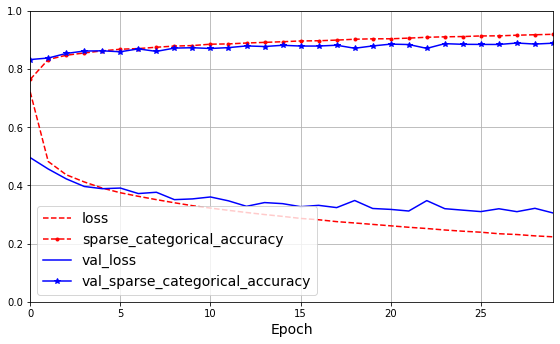

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

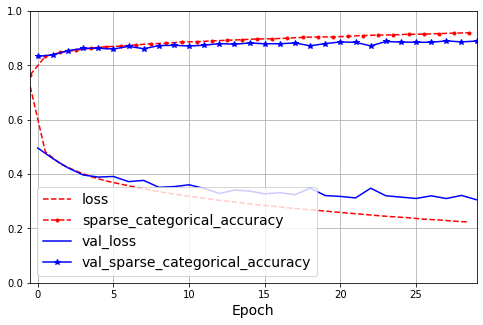

In [42]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [43]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 867us/step - loss: 0.3243 - sparse_categorical_accuracy: 0.8864


[0.32431697845458984, 0.8863999843597412]

### Using the model to make predictions

In [44]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [45]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [46]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [47]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

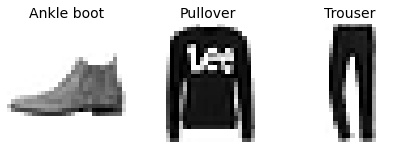

In [48]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()